In [7]:
import pandas as pd

file_location = "data1/"
plate_name = "Plate0_setup"
file_name = file_location + plate_name + ".csv"

df = pd.read_csv(file_name,
                 comment = "#",
                 skipinitialspace=True)

row_name_list = df["Row"].dropna()
S_conc_list = df["S_Conc"].dropna() * 1E-3  ### convert millimolar to molar

lane_name_list = df["Column"]
E_conc_list = df["E_Conc"] * 1E-9  ### convert nanomolar to molar
kcat_list = df["kcat"] * 60        ### convert /s to /min
Vmax_list = kcat_list * E_conc_list ## Vmax from kcat and [E]
KM_list = df["KM"] * 1E-3          ### conver mM to M

### parameters to get extinction coeff for NPA at give pH value
pH = 7.0
e_NPAA = 18300  ### extinction coeff for NPA anion
pKa_NPA = 7.15 ### pKa for p-nitrophenol

### Calculated Values from the above lists
Ka = 10 ** -pKa_NPA   ### extinction coeff for NPA at given pH
H = 10 ** -pH
e_NPA = e_NPAA * (Ka / (H + Ka))

display(df)


,Column,Enzyme,E_Conc,Row,S_Conc,kcat,KM
0,1,None,0.00,A,0.005,100,0.05
1,2,None,0.00,B,0.010,100,0.05
2,3,None,0.00,C,0.020,100,0.05
3,4,1.0 nM wt1,1.00,D,0.030,100,0.05
4,5,1.0 nM wt1,1.00,E,0.060,100,0.05
5,6,1.0 nM wt1,1.00,F,0.100,100,0.05
6,7,0.5 nM wt1,0.50,G,0.200,100,0.05
7,8,0.5 nM wt1,0.50,H,0.500,100,0.05
8,9,0.5 nM wt1,0.50,NaN,NaN,100,0.05
9,10,0.25 nM wt1,0.25,NaN,NaN,100,0.05


In [8]:
### This creates the data set separate x,y data files names as lane,row

file_location = "data1/"
plate_name = "Plate0"
file_name_root = file_location + plate_name


#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

import numpy as np
import pandas as pd

eq, f = BT.get_integrated_MM_function()

time_start = 0.5
time_end = 60           ### The end time
n_points = 360          ### number of points - increase if needed

voltage_error = 0.001   ### parameters to define output range and error
random_error = 0.001
max_value = 4

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(time_start,    ### time vector (list of time points)
                   time_end + dt, 
                   dt) 

### Note: Lane names, enzyme conc list, KM list and Vmax list must all be
### same length or this will fail. Row names and row concentration lists 
### must also have equal lengths.


parameters = zip(lane_name_list, Vmax_list, KM_list)
for p in parameters:
    lane_name, Vmax_value, KM_value = p   ### unpack kcat, KM and [E]
    #print(lane_name)

    row_info = zip(row_name_list, S_conc_list)
    for row in row_info:
        row_name, S0_value = row      ### unpack row name and substrate conc
        plate_df = pd.DataFrame([])   ### start with empty dataframe
        #print(row_name)

        ### Calculate product from enzyme reaction 
        product_E = S0_value - f(t_line, S0_value, KM_value, Vmax_value)   
        product_E = np.real(product_E)  ### complex numbers fixed

        ### Calculate product from uncatalyzed reaction 
        product_NPA = S0_value - S0_value * np.exp(-1E-3 * t_line)
        product = product_E + product_NPA
        absorbance = product * e_NPA   ### result in absorbance units

        ### Add voltage error 
        fraction_transmittance  = 1 / (10 ** absorbance)                      
        fraction_transmittance = np.random.normal(fraction_transmittance, 
                                                  voltage_error, 
                                                  len(fraction_transmittance))
        absorbance = -np.log10(fraction_transmittance)

        ### Add random error
        absorbance = np.random.normal(absorbance,     
                                      random_error, 
                                      len(absorbance))   

        absorbance[absorbance > max_value] = max_value   ### cap values 
        absorbance = np.nan_to_num(absorbance,  ### replace NaN with max value
                          copy = True, 
                          nan = max_value)   

        ### insert the two data arrays into the dataframe
        plate_df["time"] = t_line
        plate_df["abs"] = absorbance

        ### Write data out to file using lane_name and row_name
        out_file_name = str(file_name_root) + "_" + str(lane_name) + "_" \
            + str(row_name) + ".csv"
        plate_df.to_csv(out_file_name, float_format='%10.4g')



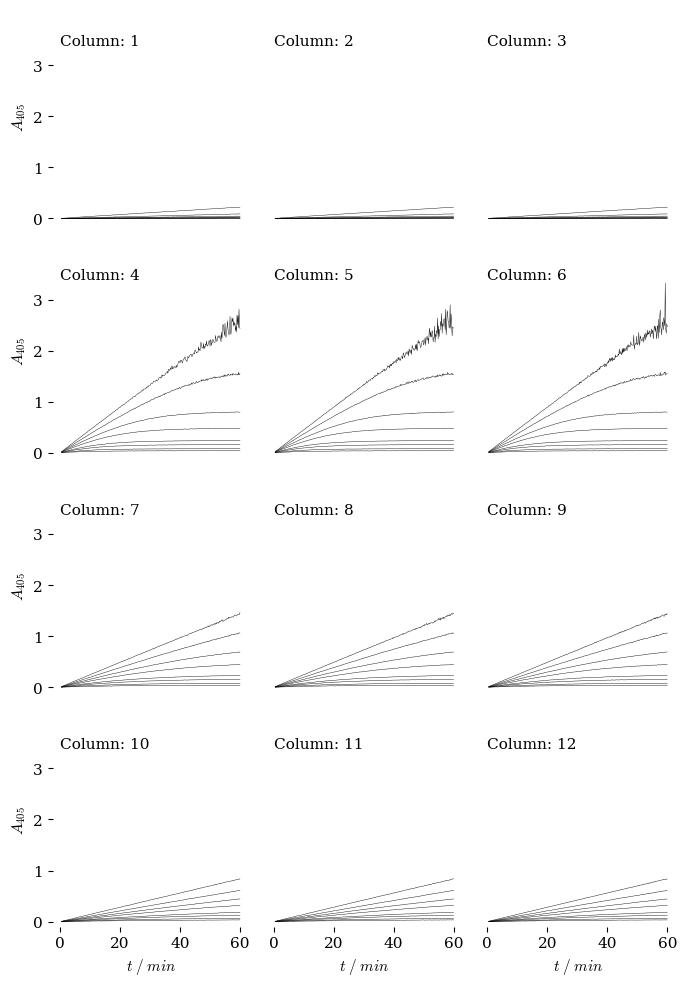

Plot saved as plot_contact_sheet.pdf


()

In [9]:
### Contact sheet. Ticks deleted on plots inside the set.
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT


BT.contact_sheet("data1/plate0", fancy = True)

In [26]:
import random
import string

for x in range(11):
   random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=3))
   print(random_string)



74V
EU4
1FJ
7DD
06Q
HHN
N4Y
ILN
KK7
LSX
AWA


In [27]:
import random

zipped =  random.sample(range(15, 233), 11), round(random.uniform(33.33, 66.66), 2)

for x in random.sample(range(15, 233), 11):
    print(str(x)+",      "+str(round(random.uniform(0.01, 0.80), 2)))

77,      0.57
104,      0.06
47,      0.67
215,      0.08
175,      0.55
24,      0.42
176,      0.23
26,      0.19
52,      0.26
68,      0.25
136,      0.11
